<h2> Use images to load inputs and targets </h2>
Load file names and targets

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# load image filenames with corresponding targets
def load_dataset(path):
    data = load_files(path)
    imgs = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 7)
    return imgs, targets

train_filenames, train_targets = load_dataset("../data/processed/train")
test_filenames, test_targets = load_dataset("../data/processed/test")

print("There are %d training images" % len(train_filenames))
print("There are %d test images" % len(test_filenames))

There are 28709 training images
There are 7178 test images


helpers to load image file

In [2]:
from keras.preprocessing import image
from tqdm import tqdm
def my_load_image(img_path):
    img = image.load_img(img_path, target_size=(48,48))
    arr = image.img_to_array(img)
    return np.expand_dims(arr, axis=0)

def my_load_images(paths):
    imgs = [my_load_image(p) for p in tqdm(paths)]
    return np.vstack(imgs)

load train image inputs

In [5]:
train_inputs = my_load_images(train_filenames)
train_inputs /= 255
test_inputs = my_load_images(test_filenames)
test_inputs /= 255

100%|████████████████████████████████████████████████████████████████████████████| 7178/7178 [00:02<00:00, 3246.37it/s]


<h2>Use csv to load inputs and targets </h2>

In [2]:
import pandas as pd
import numpy as np


names=['emotion','pixels','usage']
df=pd.read_csv('../data/processed/fer2013.csv',names=names, na_filter=False)
train_df = df[df['usage']=='Training']
validate_df = df[df['usage']=='PublicTest']
test_df = df[df['usage']=='PrivateTest']

In [3]:
def load_from_df(df):
    imgs = df['pixels']
    t = df['emotion']
    inputs = []
    targets = []
    for i in imgs.keys():
        x = [int(p) for p in imgs[i].split()]
        x = np.reshape(x,(48,48))
        y = [0 for i in range(7)]
        y[int(t[i])] = 1
        inputs.append(x)
        targets.append(y)
    inputs = np.array(inputs,dtype=np.float32)
    inputs = np.expand_dims(inputs,axis=3)
    inputs /= 255
    targets = np.array(targets, dtype=np.float32)
    return inputs, targets

In [4]:
v_inputs, v_targets = load_from_df(validate_df)
t_inputs, t_targets = load_from_df(test_df)
tr_inputs, tr_targets = load_from_df(train_df)

In [5]:
print(v_inputs.shape, t_inputs.shape)

(3589, 48, 48, 1) (3589, 48, 48, 1)


Create model

In [6]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

proto = Sequential()

proto.add(Conv2D(filters=64,kernel_size=2,padding='same',activation='relu',input_shape=(48,48,3)))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=128,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Conv2D(filters=256,kernel_size=2,padding='same',activation='relu'))
proto.add(MaxPooling2D(pool_size=2))
proto.add(Flatten())
proto.add(Dense(4096,activation='relu'))
proto.add(Dense(4096,activation='relu'))
proto.add(Dense(7,activation='softmax'))

proto.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 256)       131328    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)             

Compile

In [145]:
proto.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train model

In [146]:
from keras.callbacks import ModelCheckpoint

epoch = 10

checkpointer = ModelCheckpoint(filepath='..\models\mycnn_prototype.hdf5',verbose=1,save_best_only= True)

hist = proto.fit(train_inputs, train_targets , 
          validation_data=(test_inputs , test_targets),
          epochs= epoch, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/10
448/449 [============================>.] - ETA: 0s - loss: 1.6478 - accuracy: 0.3439
Epoch 00001: val_loss improved from inf to 1.47964, saving model to ..\models\mycnn_prototype.hdf5
449/449 [==============================] - 41s 90ms/step - loss: 1.6476 - accuracy: 0.3439 - val_loss: 1.4796 - val_accuracy: 0.4333
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.3877 - accuracy: 0.4657
Epoch 00002: val_loss improved from 1.47964 to 1.33193, saving model to ..\models\mycnn_prototype.hdf5
449/449 [==============================] - 42s 93ms/step - loss: 1.3877 - accuracy: 0.4657 - val_loss: 1.3319 - val_accuracy: 0.4781
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.5192
Epoch 00003: val_loss improved from 1.33193 to 1.25220, saving model to ..\models\mycnn_prototype.hdf5
449/449 [==============================] - 43s 97ms/step - loss: 1.2603 - accuracy: 0.5192 - val_loss: 1.2522 - val_accuracy: 0.5188
Epoch 4/

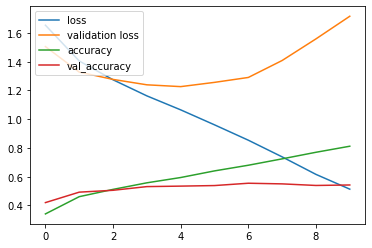

In [143]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.legend(loc="upper left")


In [88]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras import layers

model = Sequential()
model.add(layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(layers.Conv2D(256, (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2),padding="same"))
model.add(Dropout(0.25))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(layers.Dense(7, activation='softmax'))
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 48, 48, 64)        128       
_________________________________________________________________
batch_normalization_14 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_15 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
dropout_14 (Dropout)         (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 48, 48, 256)     

In [133]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [135]:
from keras.callbacks import ModelCheckpoint

vgg_epoch = 10

vgg_checkpointer = ModelCheckpoint(filepath='..\models\vgg_prototype.hdf5',verbose=1,save_best_only= True)

vgg_hist = model.fit(tr_inputs, tr_targets , 
          validation_data=(t_inputs , t_targets),
          epochs=vgg_epoch, batch_size=32, callbacks=[vgg_checkpointer], verbose=1)

Epoch 1/10
 11/898 [..............................] - ETA: 30:00 - loss: 2.3014 - accuracy: 0.1818

KeyboardInterrupt: 

In [159]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras import layers

mlp = Sequential()
mlp.add(Flatten(input_shape=(48,48)))
mlp.add(Dense(256,activation='relu'))
mlp.add(Dense(512,activation='relu'))
mlp.add(Dense(1024,activation='relu'))
mlp.add(Dense(7,activation='softmax'))
mlp.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 256)               590080    
_________________________________________________________________
dense_72 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_74 (Dense)             (None, 7)                 7175      
Total params: 1,254,151
Trainable params: 1,254,151
Non-trainable params: 0
_________________________________________________________________


In [160]:
mlp.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [161]:
mlp_epoch = 10

mlp_checkpointer = ModelCheckpoint(filepath='..\models\mlp_prototype.hdf5',verbose=1,save_best_only= True)

mlp_hist = mlp.fit(tr_inputs, tr_targets , 
          validation_data=(t_inputs , t_targets),
          epochs=mlp_epoch, batch_size=128, callbacks=[mlp_checkpointer], verbose=1)

Epoch 1/10
221/225 [============================>.] - ETA: 0s - loss: 1.7746 - accuracy: 0.2791
Epoch 00001: val_loss improved from inf to 1.74384, saving model to ..\models\mlp_prototype.hdf5
225/225 [==============================] - 2s 10ms/step - loss: 1.7733 - accuracy: 0.2795 - val_loss: 1.7438 - val_accuracy: 0.3034
Epoch 2/10
222/225 [============================>.] - ETA: 0s - loss: 1.6917 - accuracy: 0.3308
Epoch 00002: val_loss improved from 1.74384 to 1.66037, saving model to ..\models\mlp_prototype.hdf5
225/225 [==============================] - 2s 10ms/step - loss: 1.6915 - accuracy: 0.3309 - val_loss: 1.6604 - val_accuracy: 0.3466
Epoch 3/10
223/225 [============================>.] - ETA: 0s - loss: 1.6553 - accuracy: 0.3485
Epoch 00003: val_loss improved from 1.66037 to 1.63687, saving model to ..\models\mlp_prototype.hdf5
225/225 [==============================] - 2s 11ms/step - loss: 1.6552 - accuracy: 0.3485 - val_loss: 1.6369 - val_accuracy: 0.3589
Epoch 4/10
222/22